In [6]:
import os
import sys

DEFAULT_DEVICE = 'cpu'
os.environ['JAX_PLATFORM_NAME'] = DEFAULT_DEVICE

try:
    from tinygp import GaussianProcess, kernels
except:
    %pip install -qqq tinygp
    from tinygp import GaussianProcess, kernels

import jax
import jax.numpy as jnp
import numpy as np
import jaxopt
import optax
import matplotlib.pyplot as plt
import pandas as pd

print("The following devices should match with each other. If they don't, restart the kernel")
print(os.environ['JAX_PLATFORM_NAME'])
print(jax.default_backend())
print(jnp.array(1.).device())

The following devices should match with each other. If they don't, restart the kernel
cpu
cpu
TFRT_CPU_0


## Functions

In [2]:
def build_gp(params, x):
    log_kernel, mean, log_noise = params
    kernel = jax.tree_map(jnp.exp, log_kernel)
    noise = jnp.exp(log_noise)
    return GaussianProcess(kernel, x, diag=noise, mean=mean)

@jax.jit
@jax.value_and_grad
def loss_and_grad(params, x, y):
    params, x, y = data
    gp = build_gp(params, x)
    return -gp.log_probability(y)

def optimize_optax(data, epochs, optimizer='optax'):
    params, x, y = data
    if optimizer == 'optax':
        tx = optax.adam(learning_rate=0.1)
        state = tx.init(params)
        for _ in range(epochs):
            val, grads = loss_and_grad(params, x, y)
            updates, state = tx.update(grads, state)
            params = optax.apply_updates(params, updates)
    if optimizer == 'jaxopt':
        

def simulate_data(key, N):
    x = jnp.linspace(-2, 2, N).reshape(-1,1)
    y = jnp.sin(x).flatten() + jax.random.normal(key, shape=(N,))
    
    kernel = jnp.array(1.) * kernels.ExpSquared()
    mean = jnp.array(1.)
    noise = jnp.array(1.)
    return (kernel, mean, noise), x, y

### Config

In [3]:
N_RANGE = range(1000, 11000, 1000)
EPOCHS_RANGE = range(100, 1100, 100)

### Training

In [ ]:
res_df = pd.DataFrame(index=N_RANGE, columns=EPOCHS_RANGE)
key = jax.random.PRNGKey(0)

# Warm up
data = simulate_data(key, N=10)
optimize_optax(data, epochs=10)

key_n = 0
for N in N_RANGE:
    for EPOCHS in EPOCHS_RANGE:
        key_n += 1
        key = jax.random.PRNGKey(key_n)
        data = simulate_data(key, N)
        res = %timeit -n1 -r1 -o optimize_optax(data, epochs=EPOCHS)
        res_df.loc[N, EPOCHS] = res.average
        print(f"N: {N}, EPOCHS: {EPOCHS}, TIME: {res.average}")

pd.to_pickle(res_df, f"results/simple_{DEFAULT_DEVICE}_timings.pkl")

/home/zeelp/miniconda/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


4.65 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
N: 1000, EPOCHS: 100, TIME: 4.646775339002488
6.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
N: 1000, EPOCHS: 200, TIME: 6.5214199050024035
7.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
N: 1000, EPOCHS: 300, TIME: 7.6867540550010744
9.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
N: 1000, EPOCHS: 400, TIME: 9.289961458998732
10.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
N: 1000, EPOCHS: 500, TIME: 10.553404967999086
10.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
N: 1000, EPOCHS: 600, TIME: 10.698266998995678
9.92 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
N: 1000, EPOCHS: 700, TIME: 9.924027528999432
13.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
N: 1000, EPOCHS: 800, TIME: 13.388653641995916
16.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
N: 1000, EPOCHS: 900, TIME: 16.94671510999615
18.9 

### Plot the timings

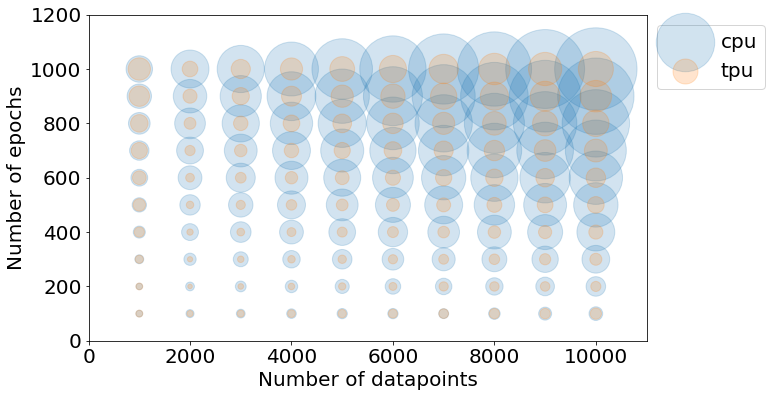

In [18]:
SCALE = 10

def get_results(device):
    df = pd.read_pickle(f"results/simple_{device}_timings.pkl")
    n_grid, epoch_grid = map(np.ravel, np.meshgrid(df.index, df.columns))
    time_grid = df.values.flatten().astype(np.float32)
    return n_grid, epoch_grid, time_grid, df

cpu_n, cpu_epochs, cpu_time, cpu_df = get_results('cpu')
tpu_n, tpu_epochs, tpu_time, tpu_df = get_results('tpu')

plt.figure(figsize=(10,6))
plt.rc('font', size=20)
plt.scatter(cpu_n, cpu_epochs, s=SCALE*cpu_time, label="cpu", alpha=0.2)
plt.scatter(tpu_n, tpu_epochs, s=SCALE*tpu_time, label="tpu", alpha=0.2)
plt.xlabel('Number of datapoints')
plt.ylabel('Number of epochs');
plt.ylim(0,1200);
plt.xlim(0,11000);
plt.legend(bbox_to_anchor=(1,1));

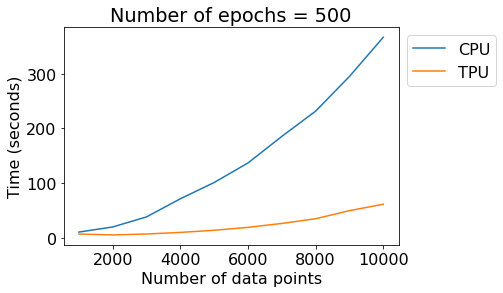

In [53]:
plt.rc('font', size=16)
plt.plot(cpu_df.loc[:,500], label='CPU');
plt.plot(tpu_df.loc[:,500], label='TPU');
obj = plt.legend(bbox_to_anchor=(1,1));
plt.xlabel('Number of data points')
plt.ylabel('Time (seconds)');
plt.title('Number of epochs = 500');